In [7]:
%pip freeze > requirements.txt
%pip install -r requirements.txt
import requests
from IPython.display import GeoJSON
import pandas as pd
import io
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


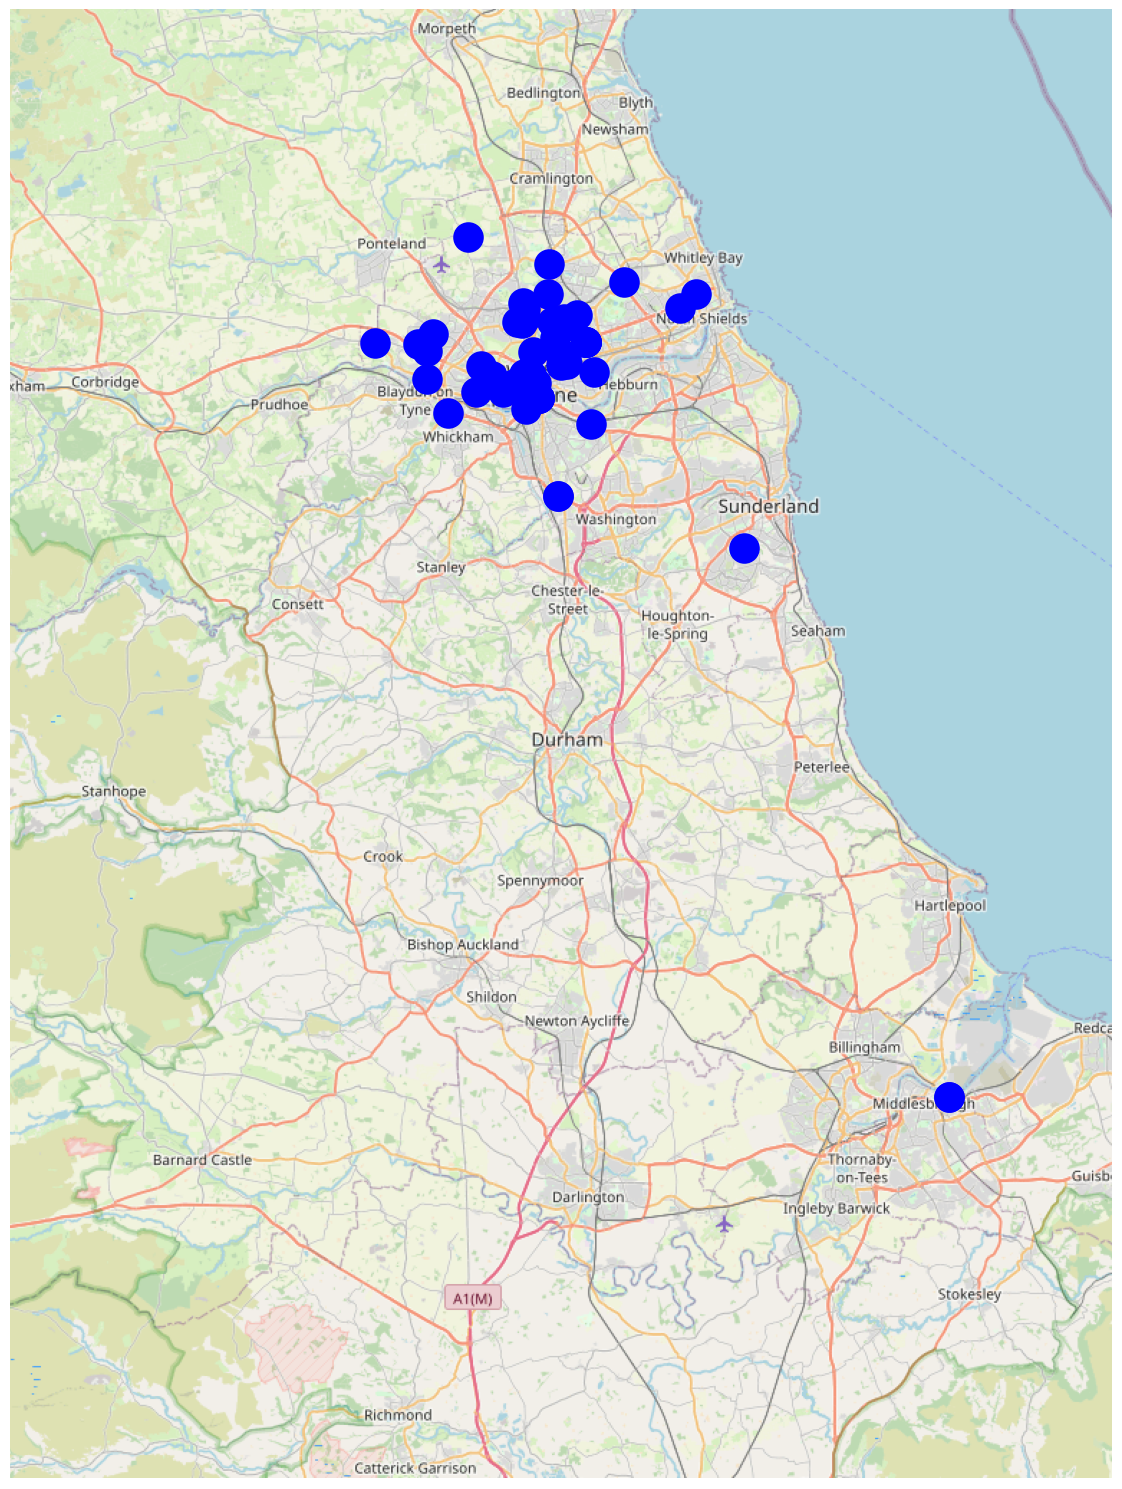

In [4]:
import smopy
import matplotlib.patheffects as pe

sensor_params_pm2 = dict(
    sensor_type='PM2.5')

sensor_params_pm10 = dict(
    sensor_type='PM10')

sensor_params_no2 = dict(
    sensor_type='NO2')

def create_map(sensor_params):
    r = requests.get('http://uoweb3.ncl.ac.uk/api/v1.1/sensors/csv/',sensor_params)

    sensor_info = pd.read_csv(io.StringIO(r.text) )
    sensor_info
    
    bbox = (
    min(sensor_info['Sensor Centroid Latitude']),
        min(sensor_info['Sensor Centroid Longitude']),
        max(sensor_info['Sensor Centroid Latitude']),
        max(sensor_info['Sensor Centroid Longitude']),
    )

    map = smopy.Map(bbox, z=10)
    ax = map.show_mpl(figsize=(15, 15))
    for i,row in sensor_info.iterrows():
        x, y = map.to_pixels(row['Sensor Centroid Latitude'], row['Sensor Centroid Longitude'])
        ax.plot(x, y, 'ob', ms=20, mew=2);
        
        
create_map(sensor_params_pm2)

In [8]:
class AggData:
    instances = []
    data_params = {}
    df = pd.DataFrame()

    def __init__(self, variable):
        # Set up parameters
        self.data_params = dict(
            data_variable=variable,
            agg_method='median',
            agg_period='15mins',
            starttime=(datetime.now() - timedelta(days=1)).strftime("%Y%m%d%H%M%S"),
            endtime=datetime.now().strftime("%Y%m%d%H%M%S"),
            sensor_type=variable
        )

        # Call fetch data method
        self.df = AggData.FetchAggData(self.data_params)

        # Append to instances of this class
        AggData.instances.append(self)

    @classmethod
    def FetchAggData(cls, data_params):
        r = requests.get('http://uoweb3.ncl.ac.uk/api/v1.1/sensors/data/agg/csv/', data_params)
        df = pd.read_csv(io.StringIO(r.text))
        return df

    def __str__(self):
        return f"{self.data_params['data_variable']}"


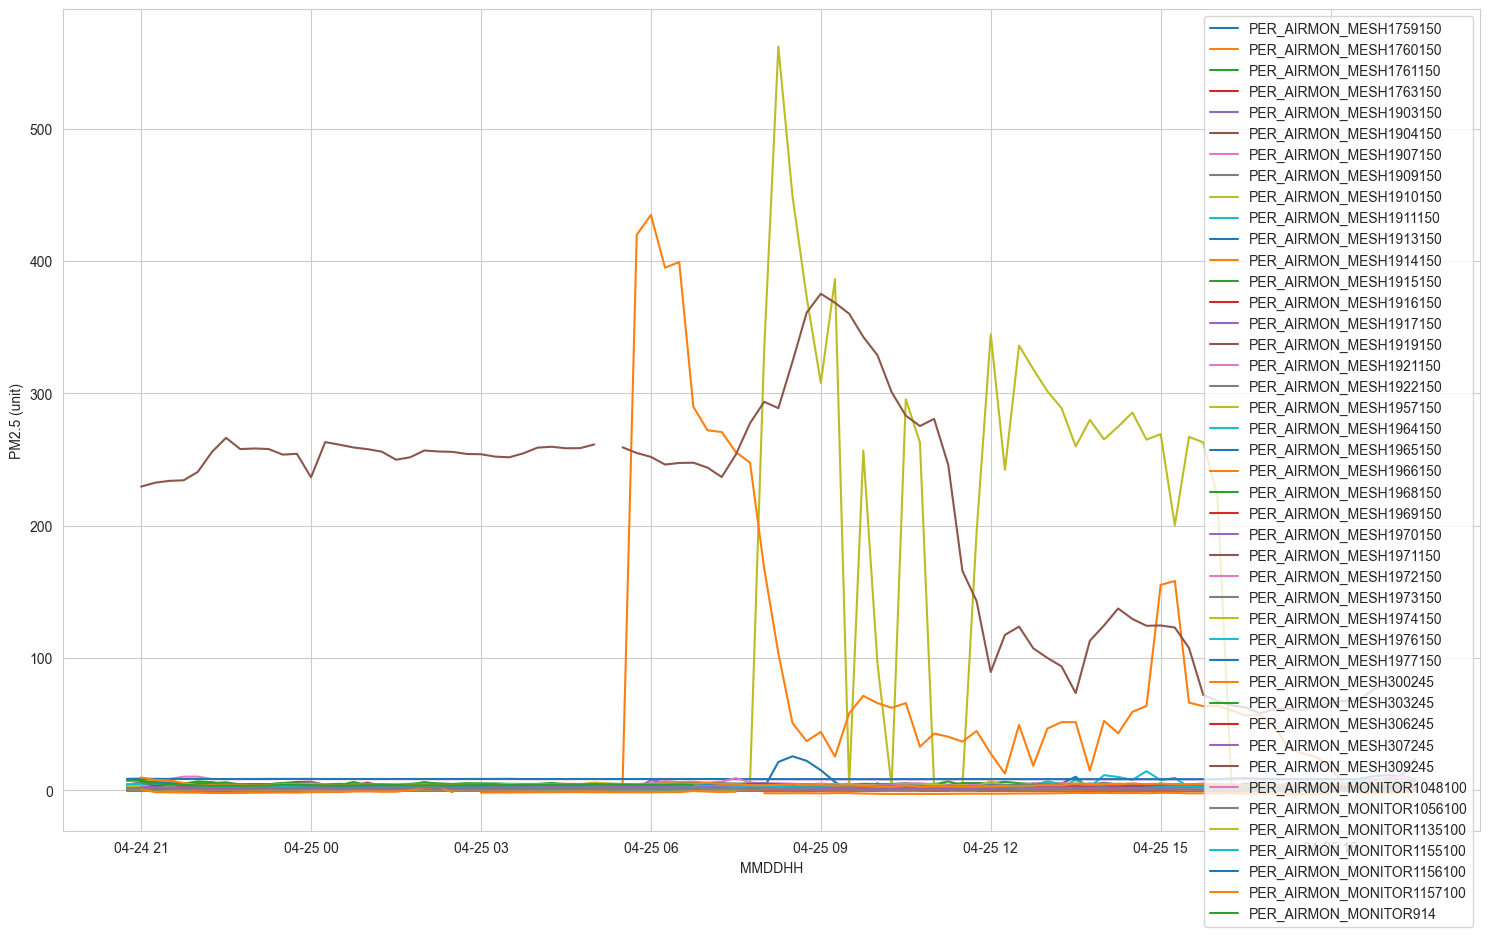

In [53]:
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

def plot_line_graph(df, data_params, figsize=(15, 10)):
    fig, ax = plt.subplots(figsize=figsize)

    for sensor_name, sensor_data in df.groupby('Sensor Name'):
        datetimes = pd.to_datetime(sensor_data['Timestamp'])
        plt.plot(datetimes, sensor_data['Value'], label=sensor_name)
        plt.xlabel("MMDDHH")
        # Add units to the y-axis label
        ylabel = f"{data_params['data_variable']} (unit)"
        plt.ylabel(ylabel)

    plt.legend()
    plt.tight_layout()

    
a = AggData("PM2.5")
plot_line_graph(a.df, a.data_params)

 


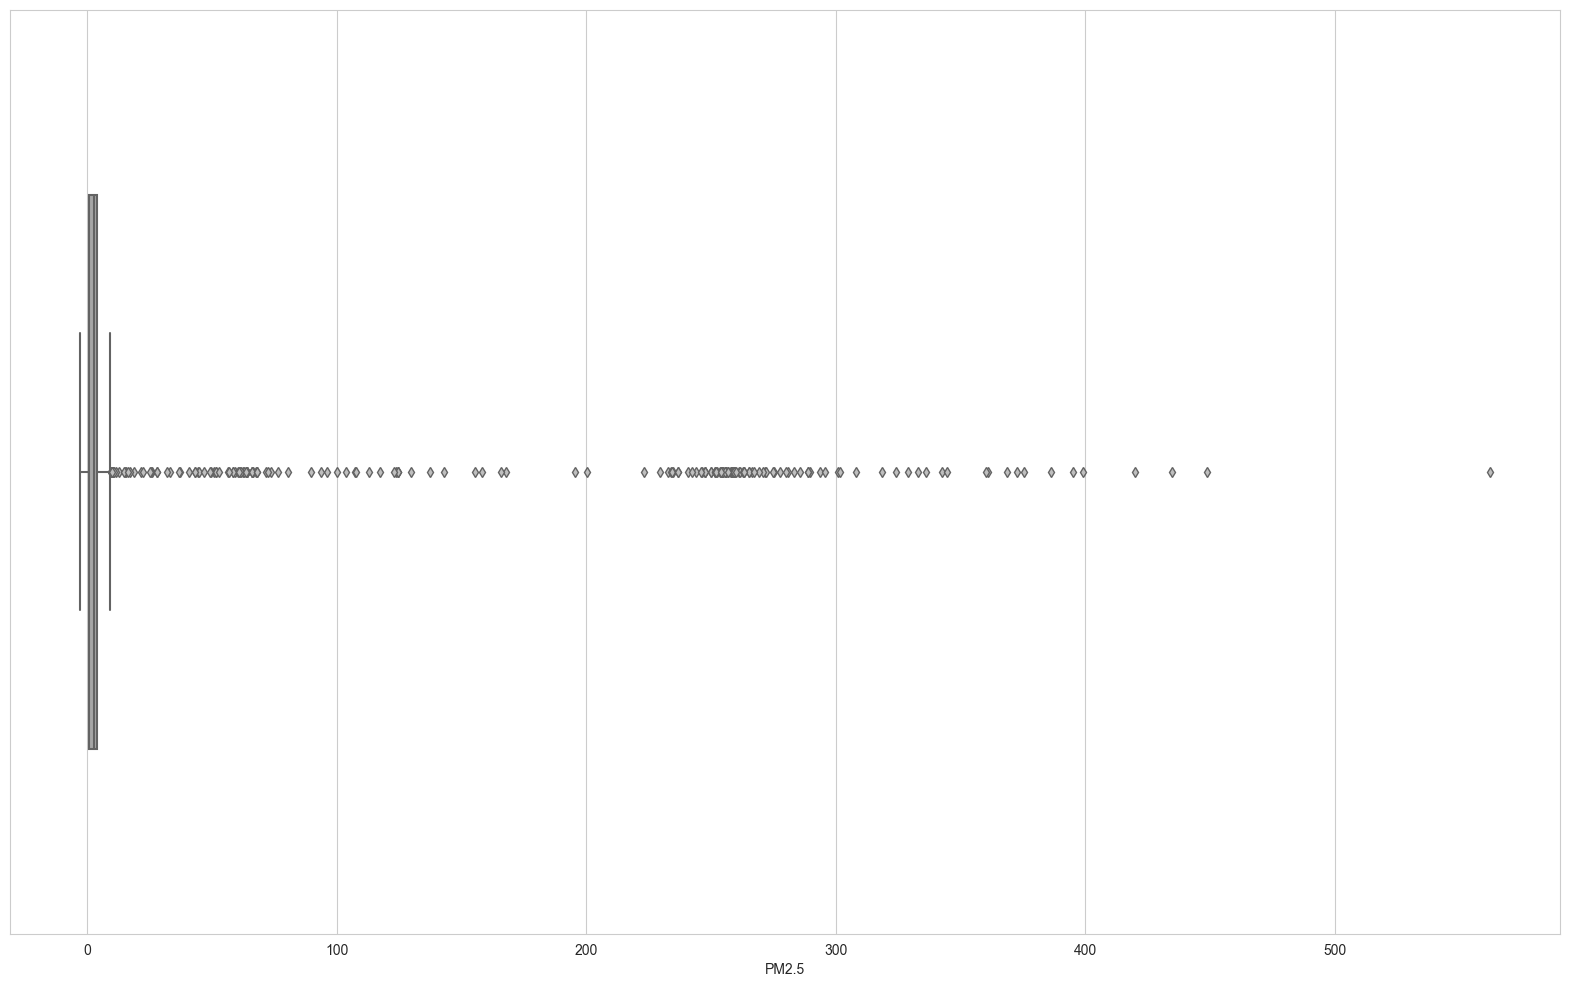

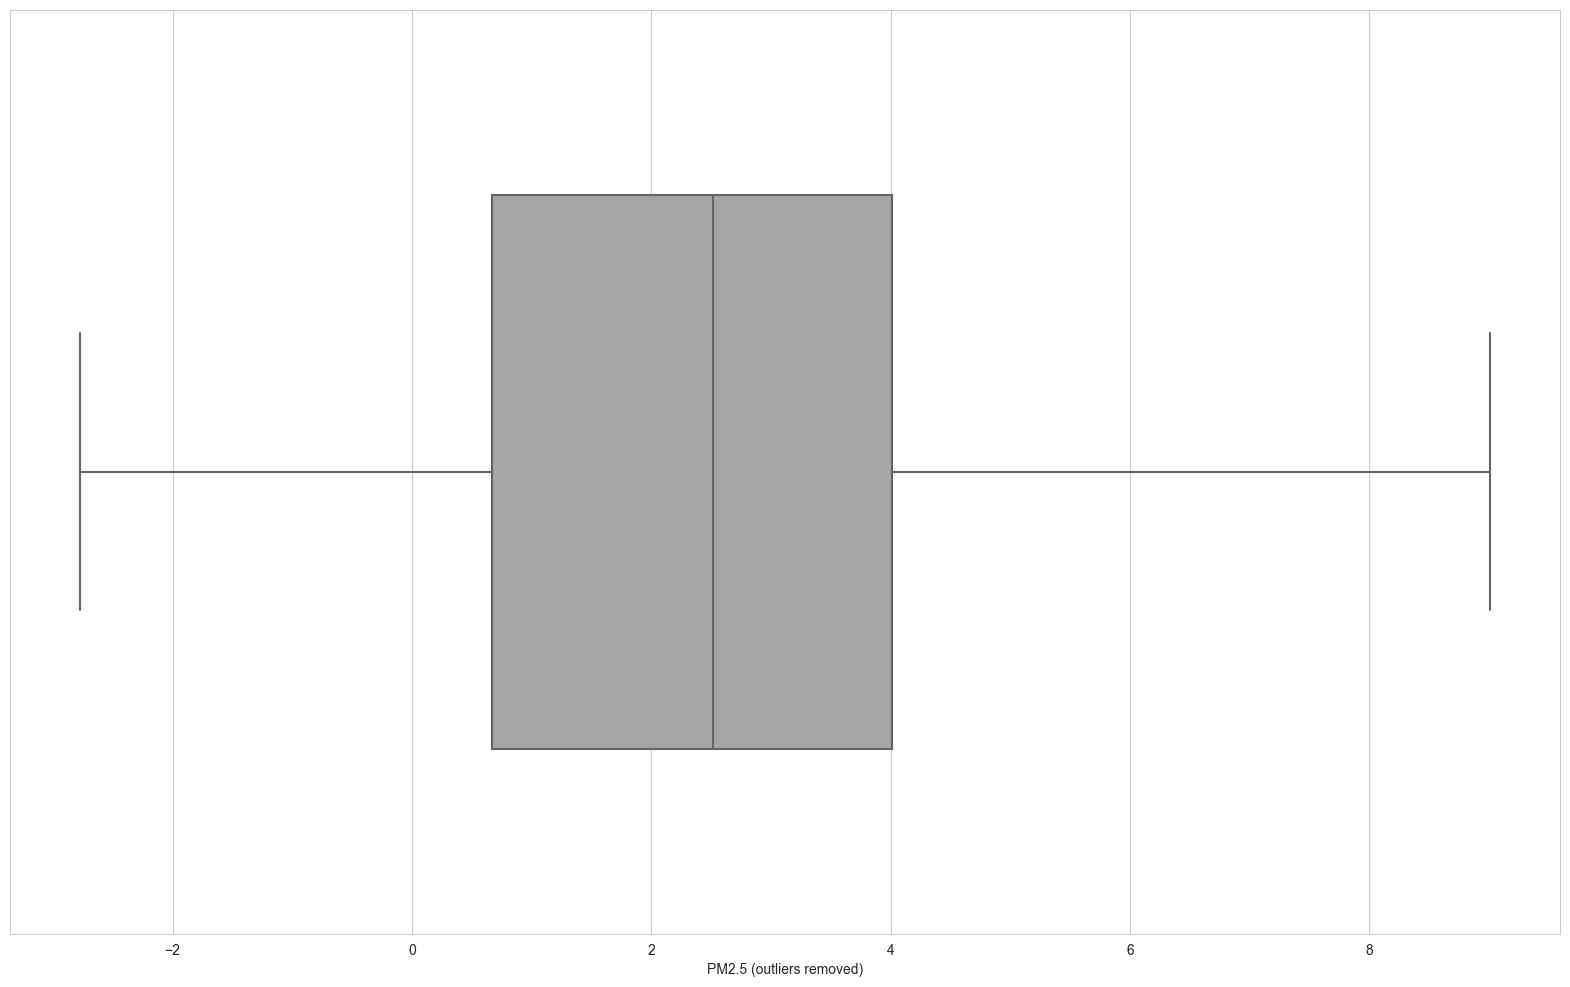

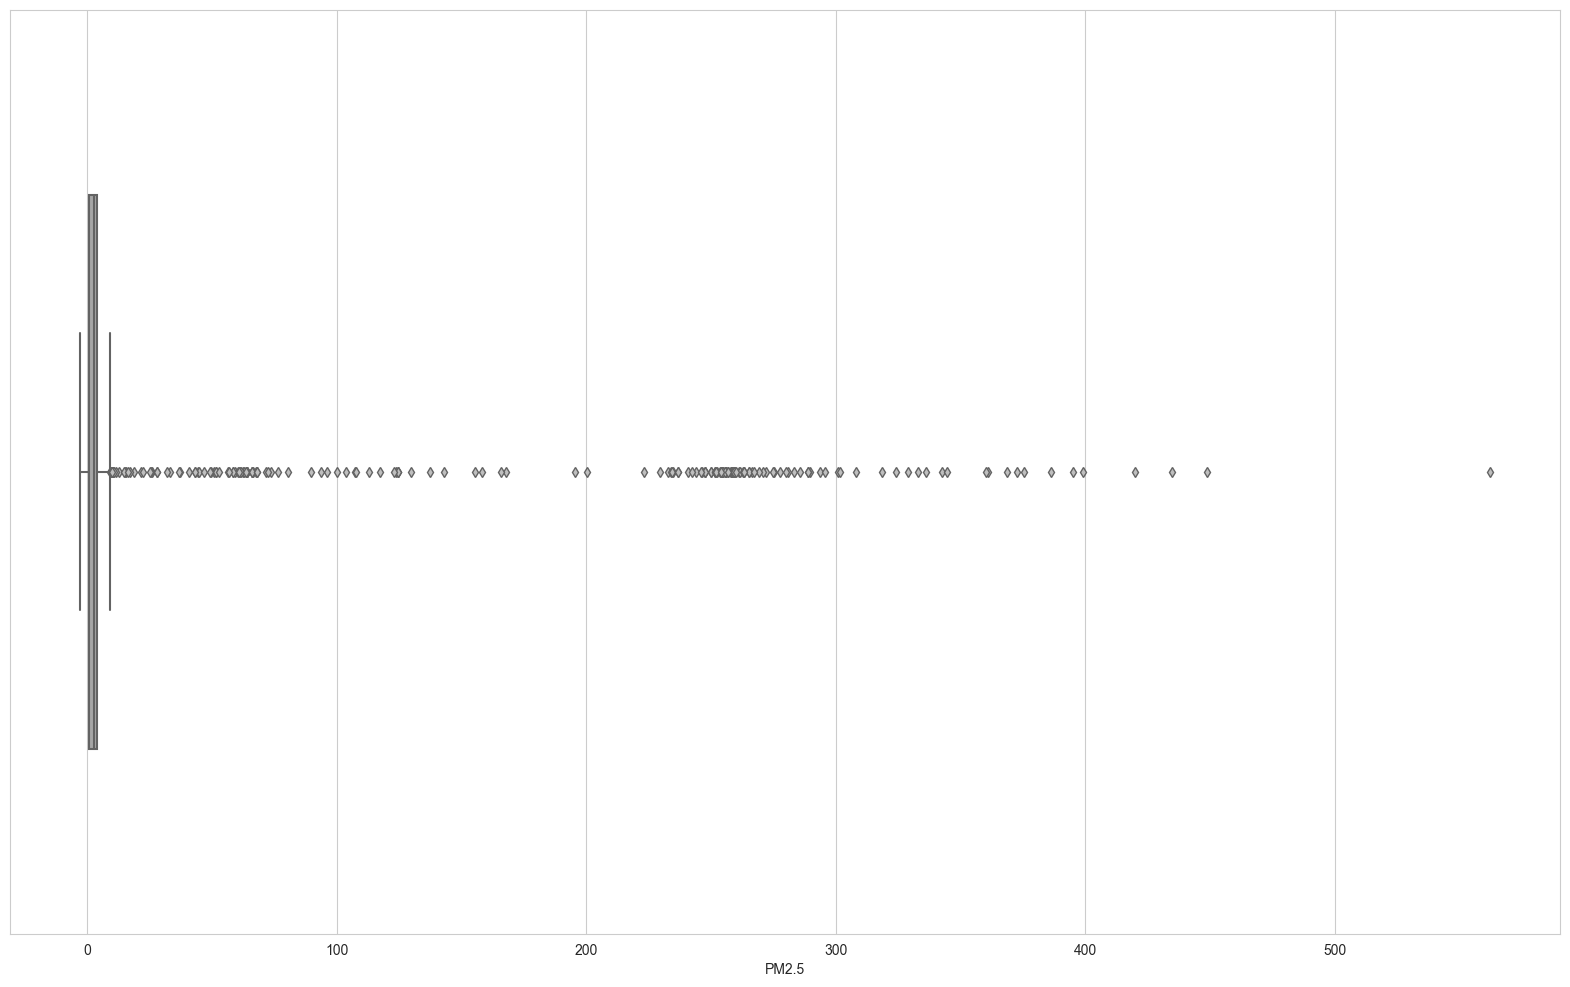

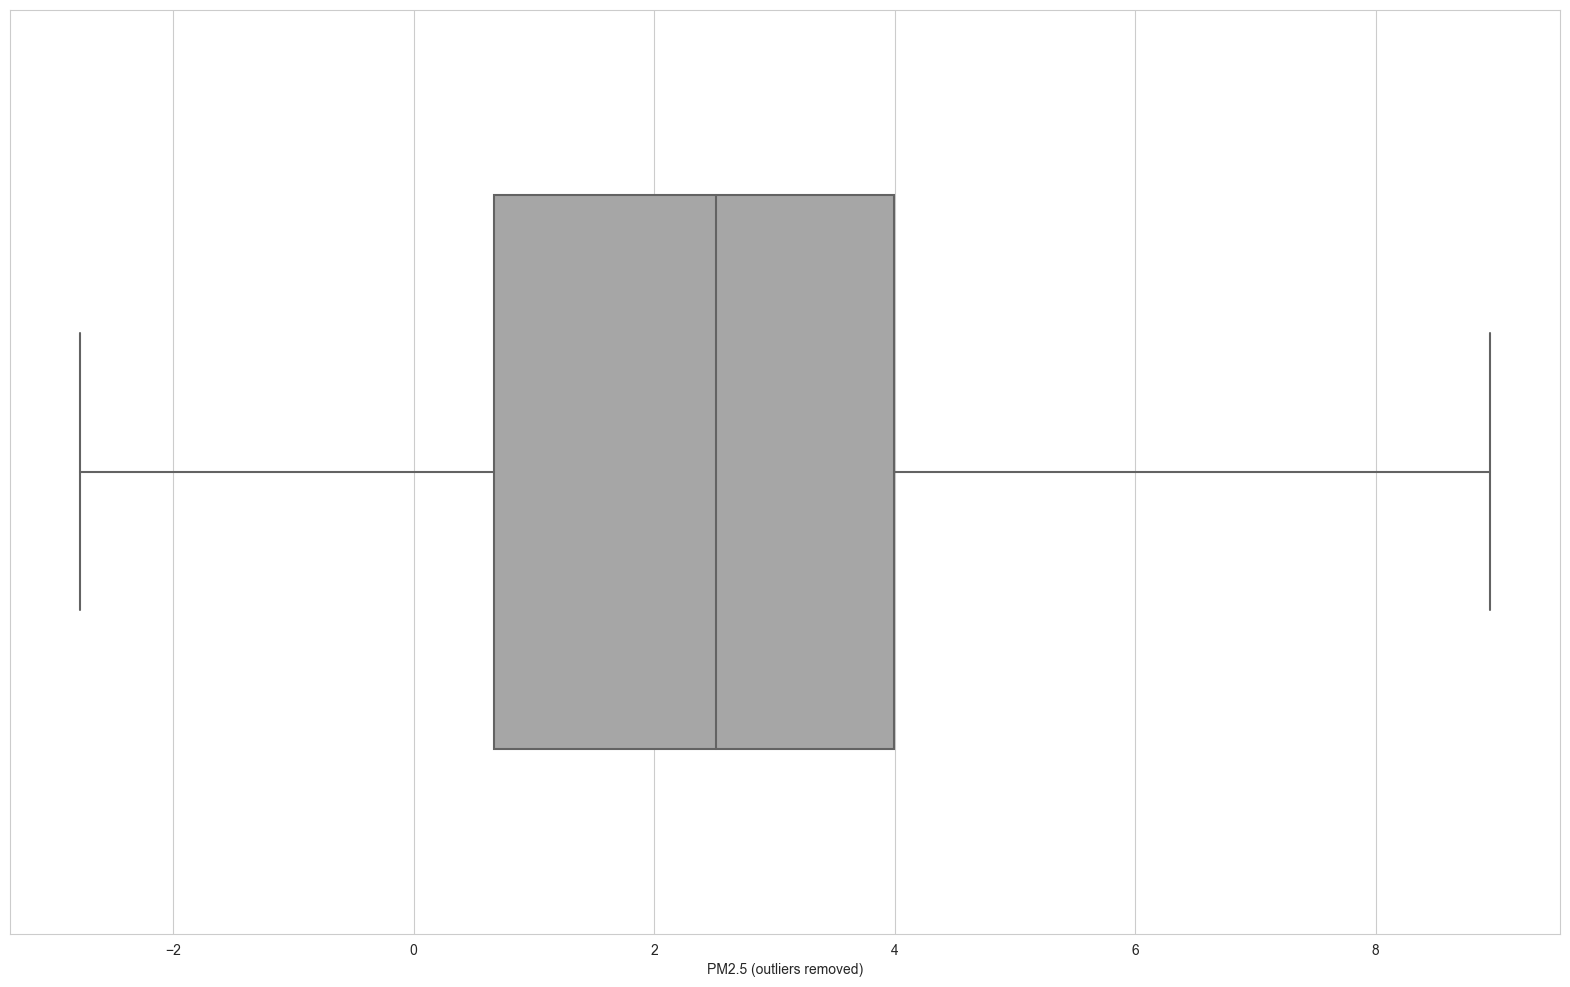

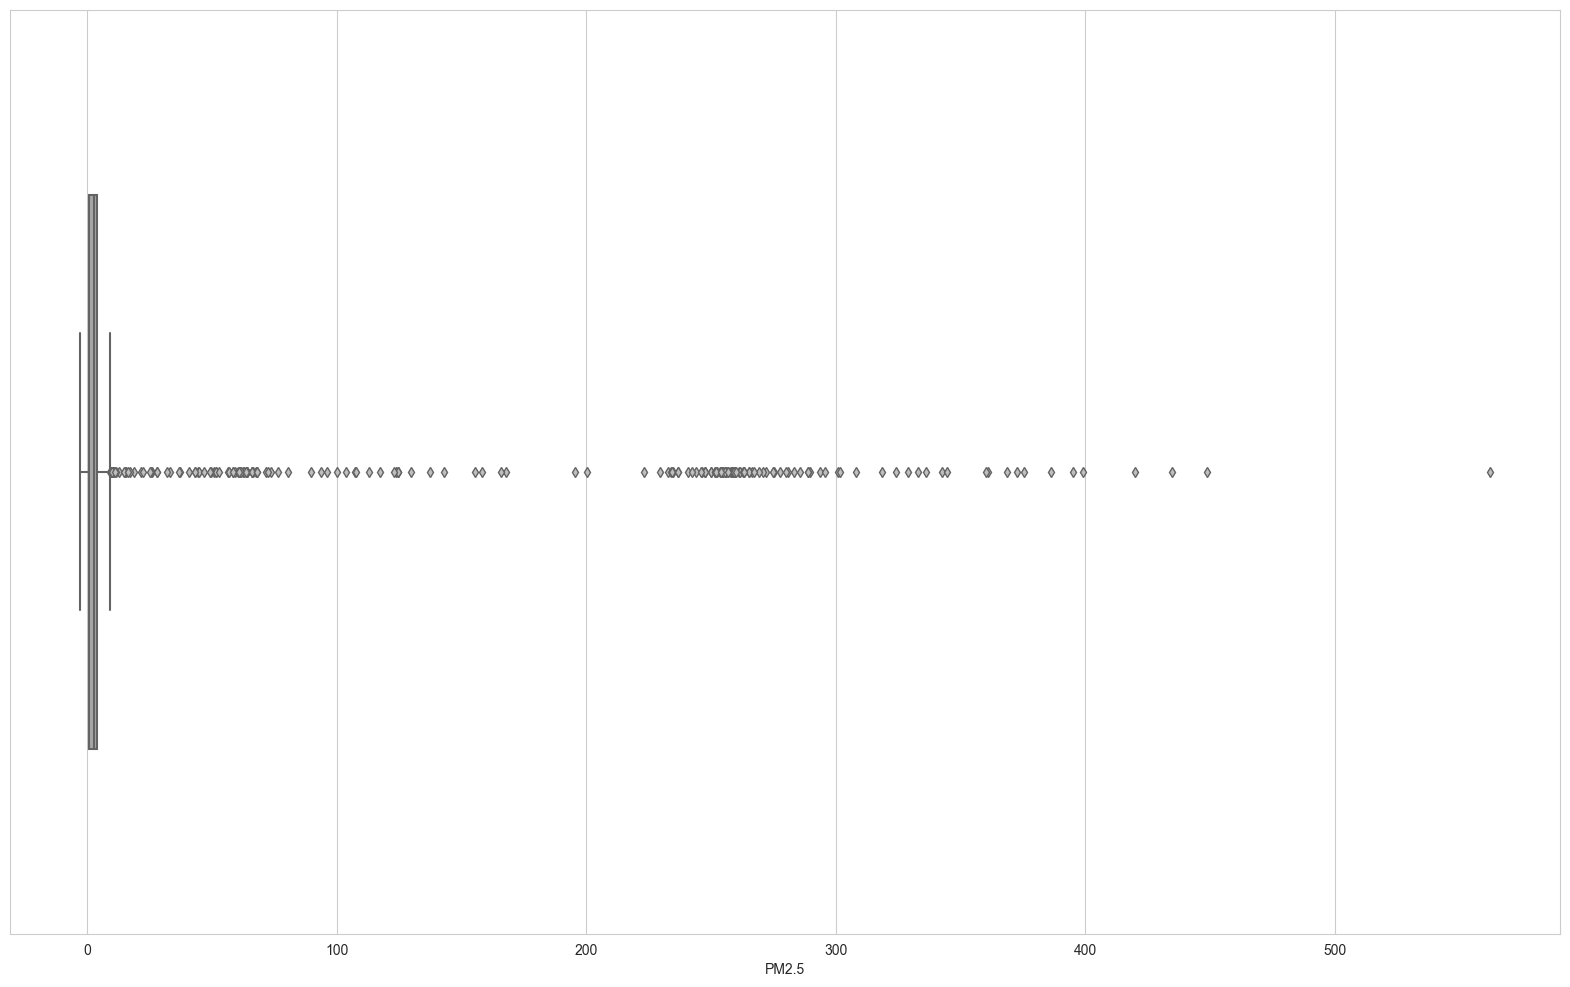

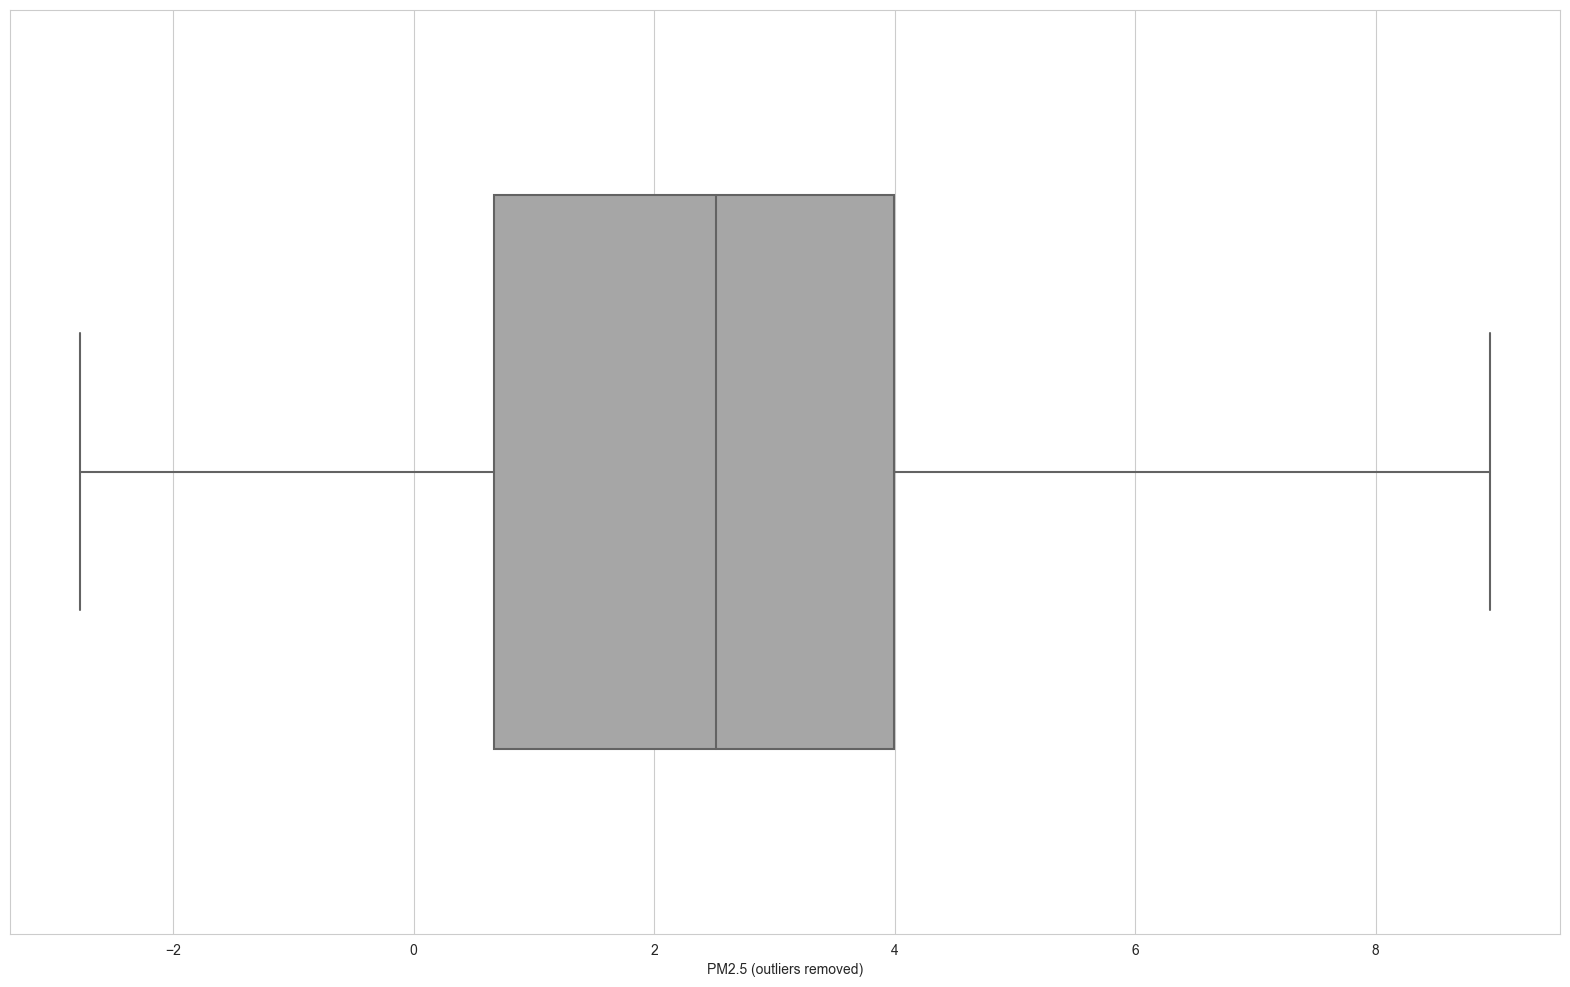

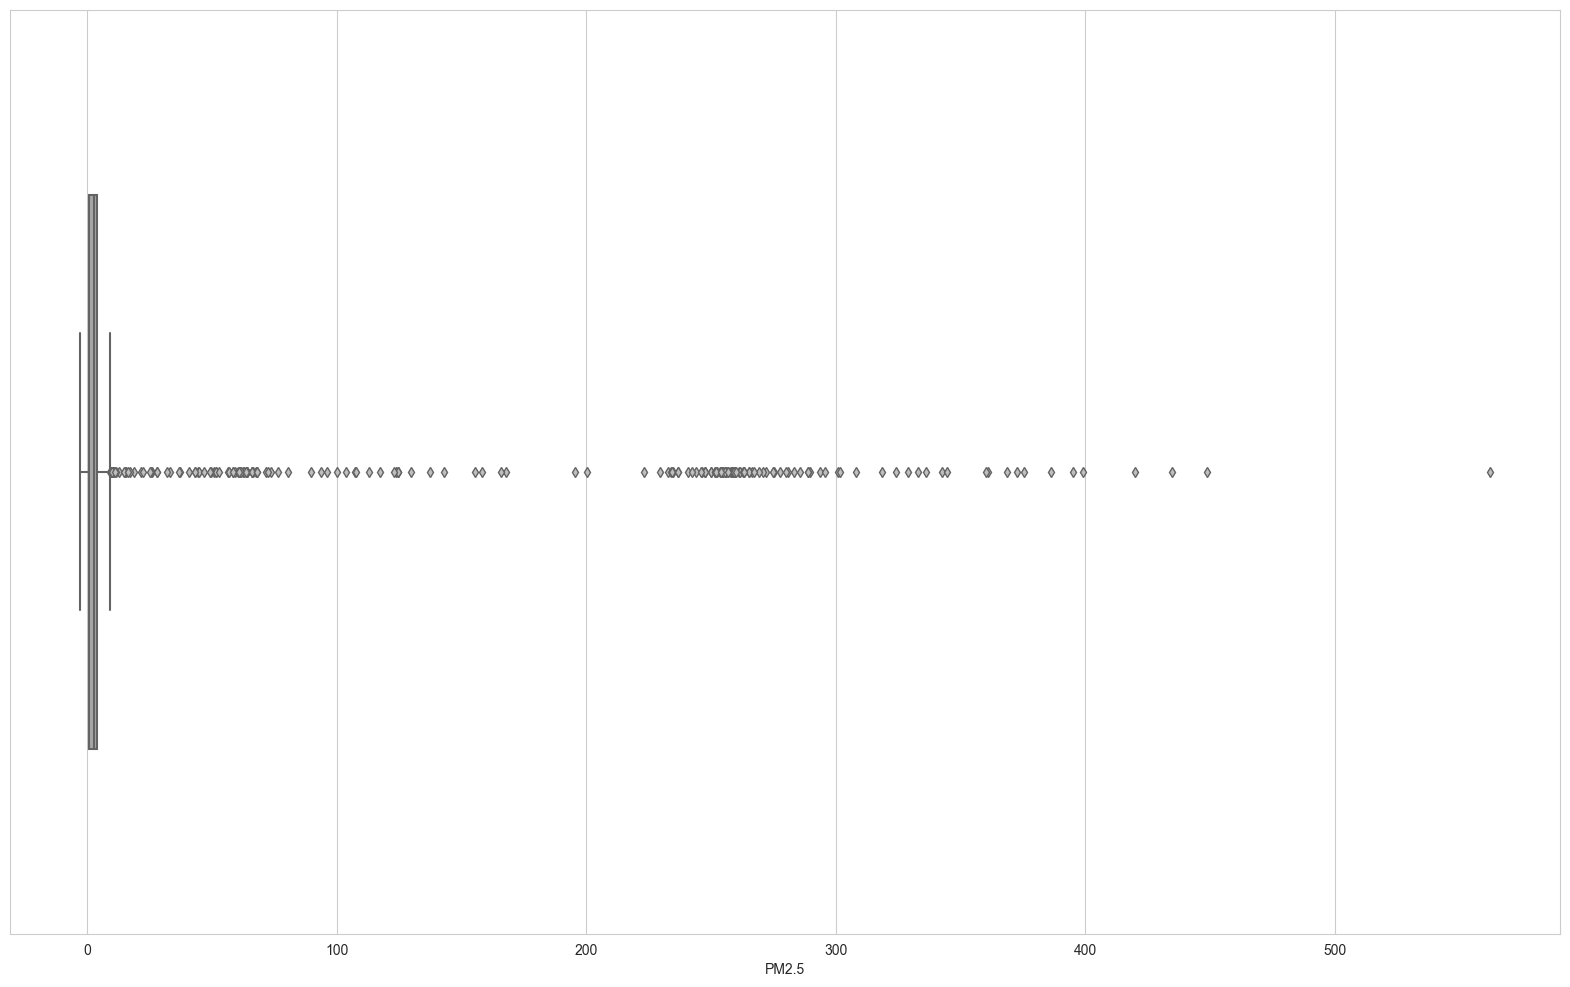

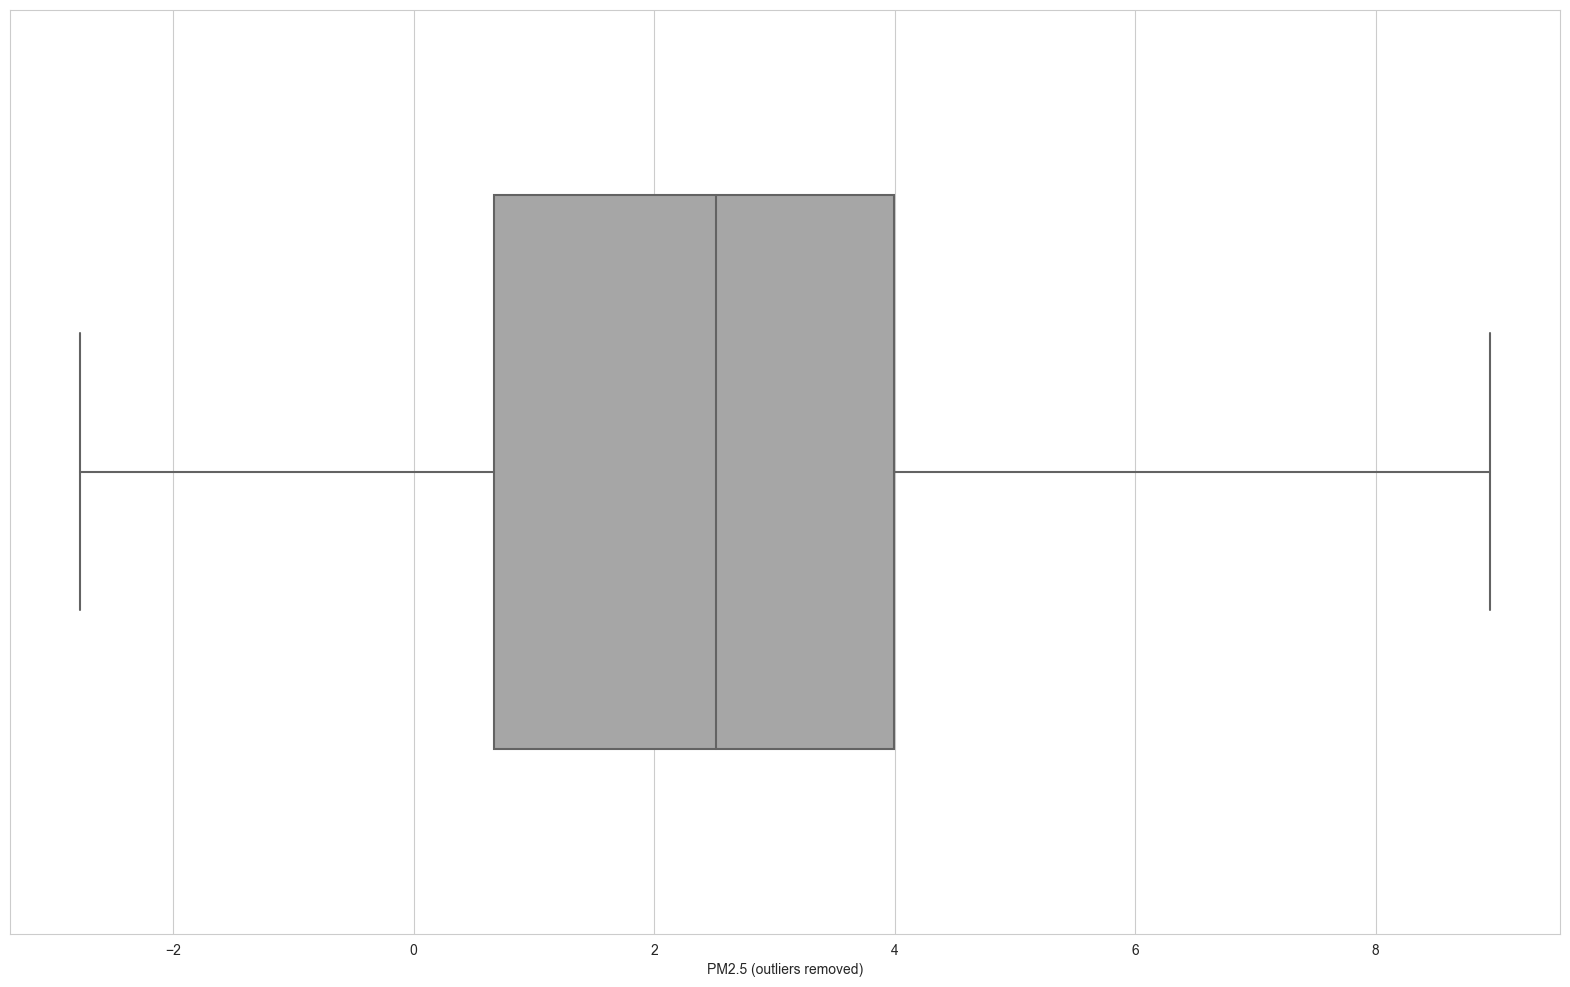

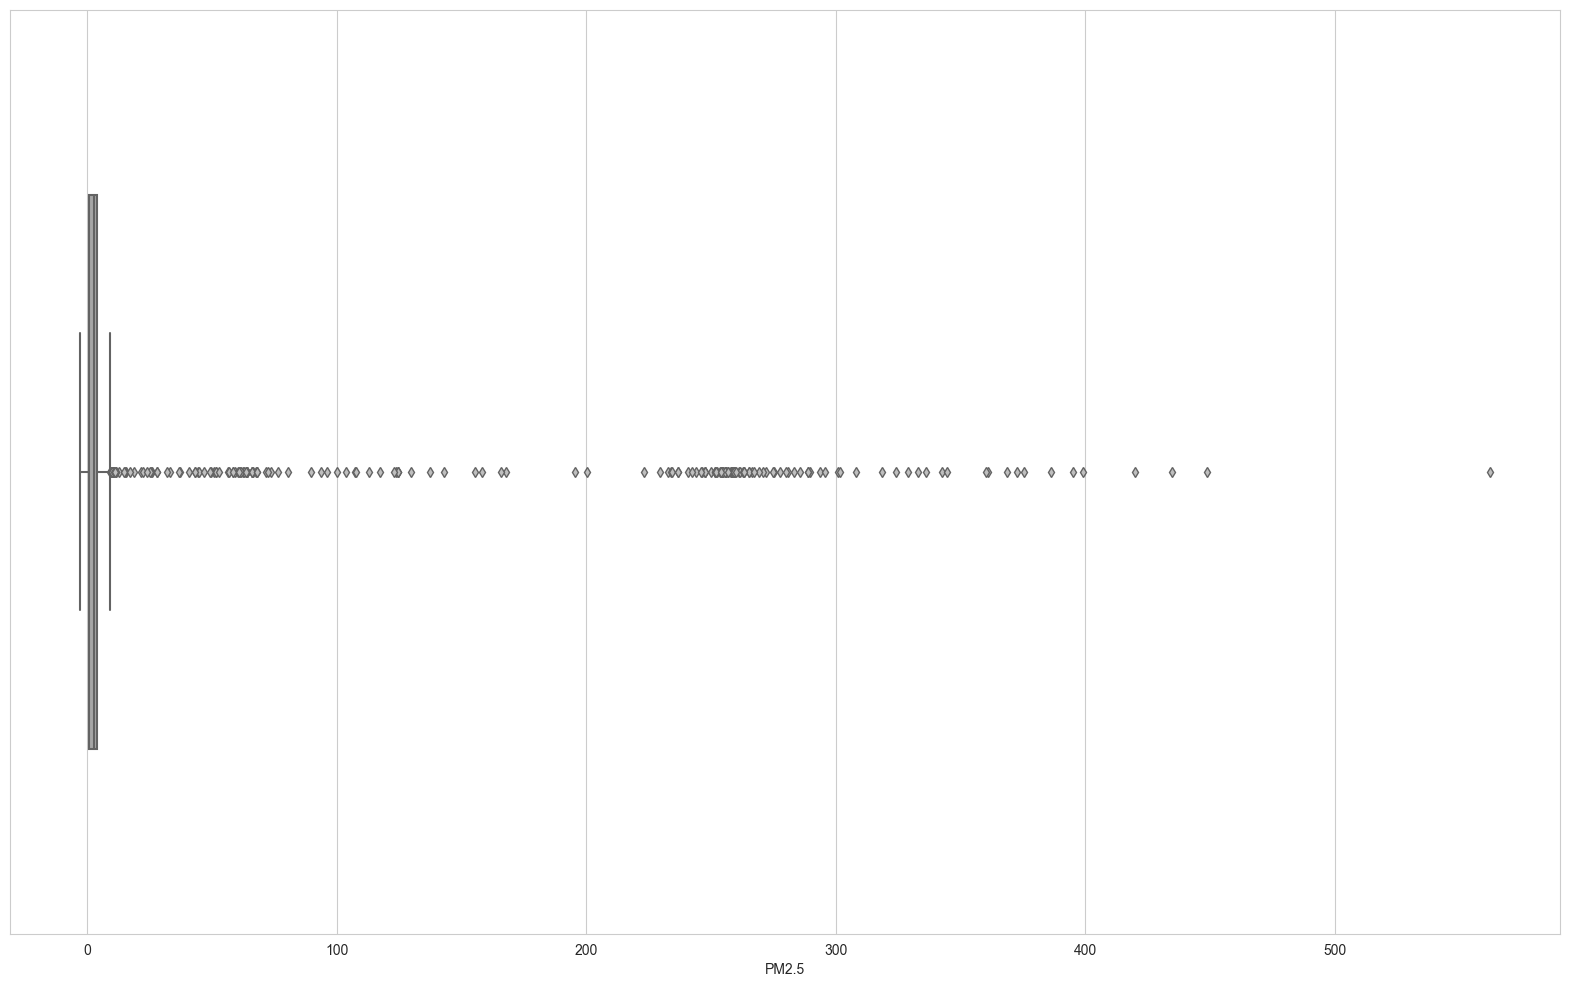

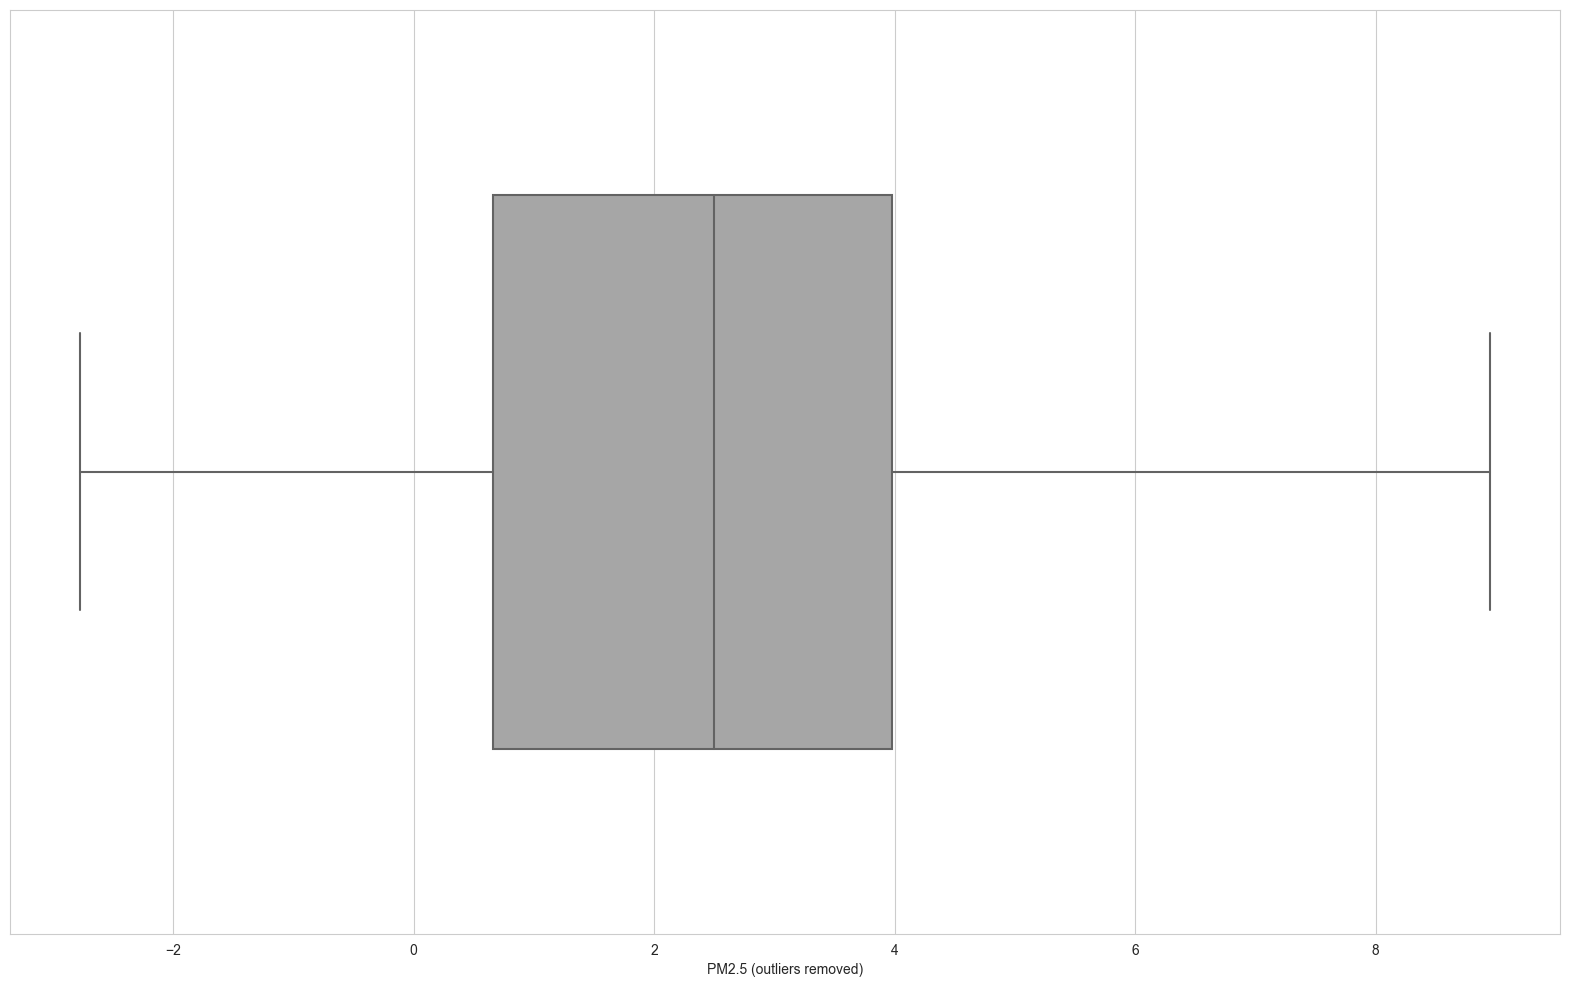

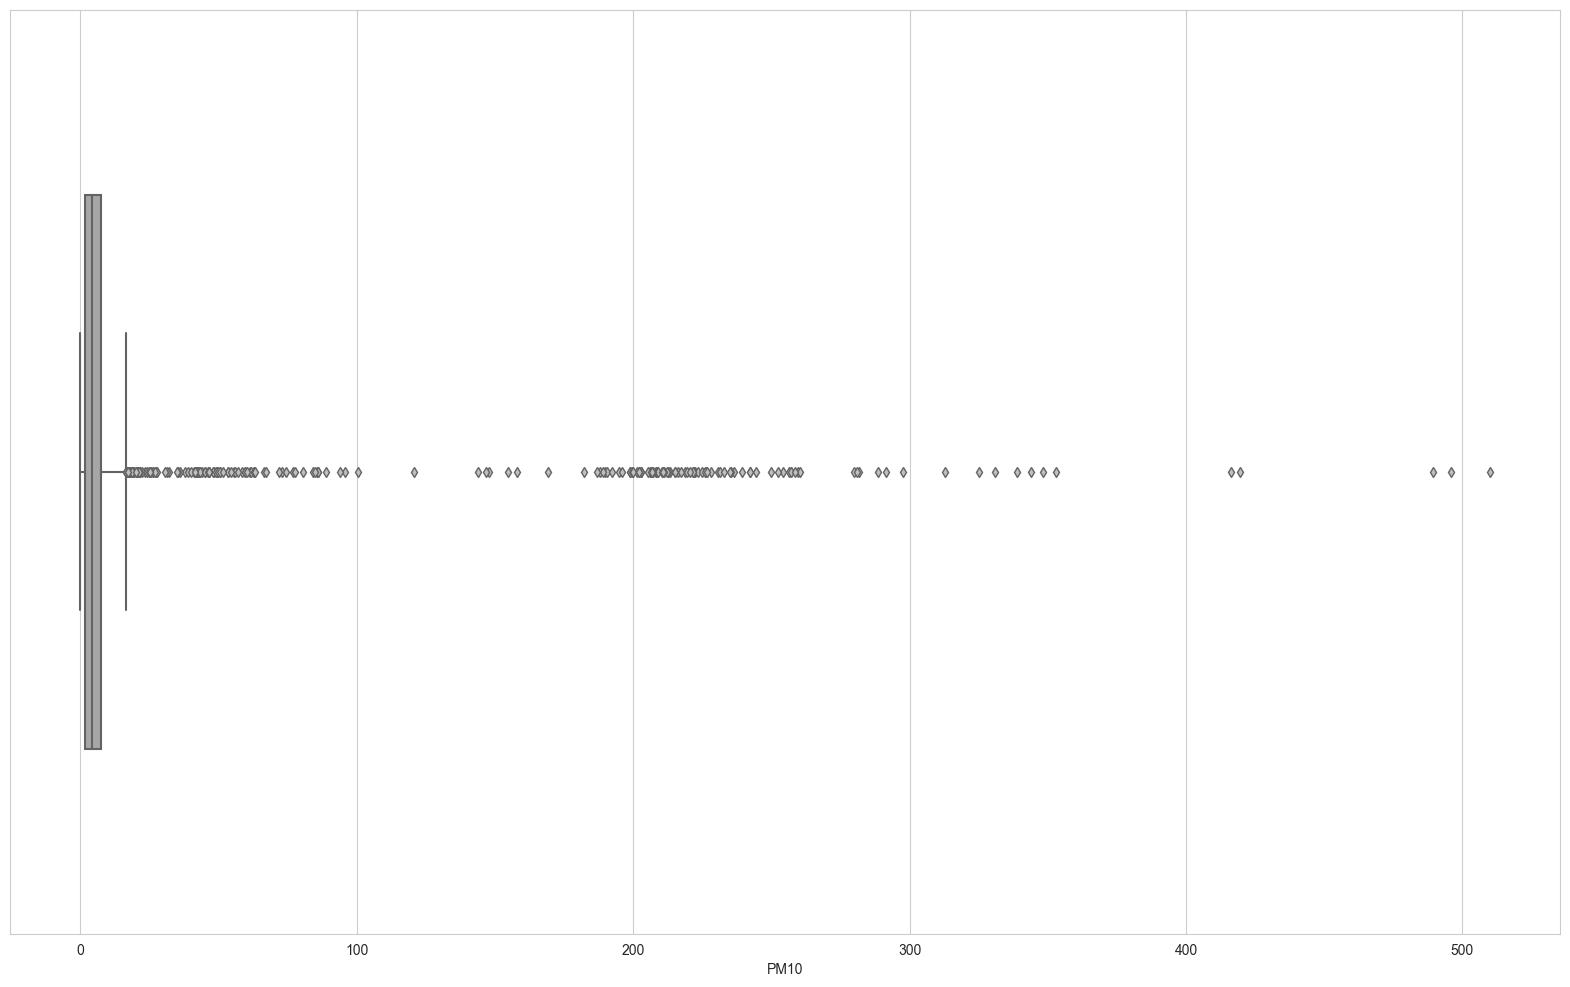

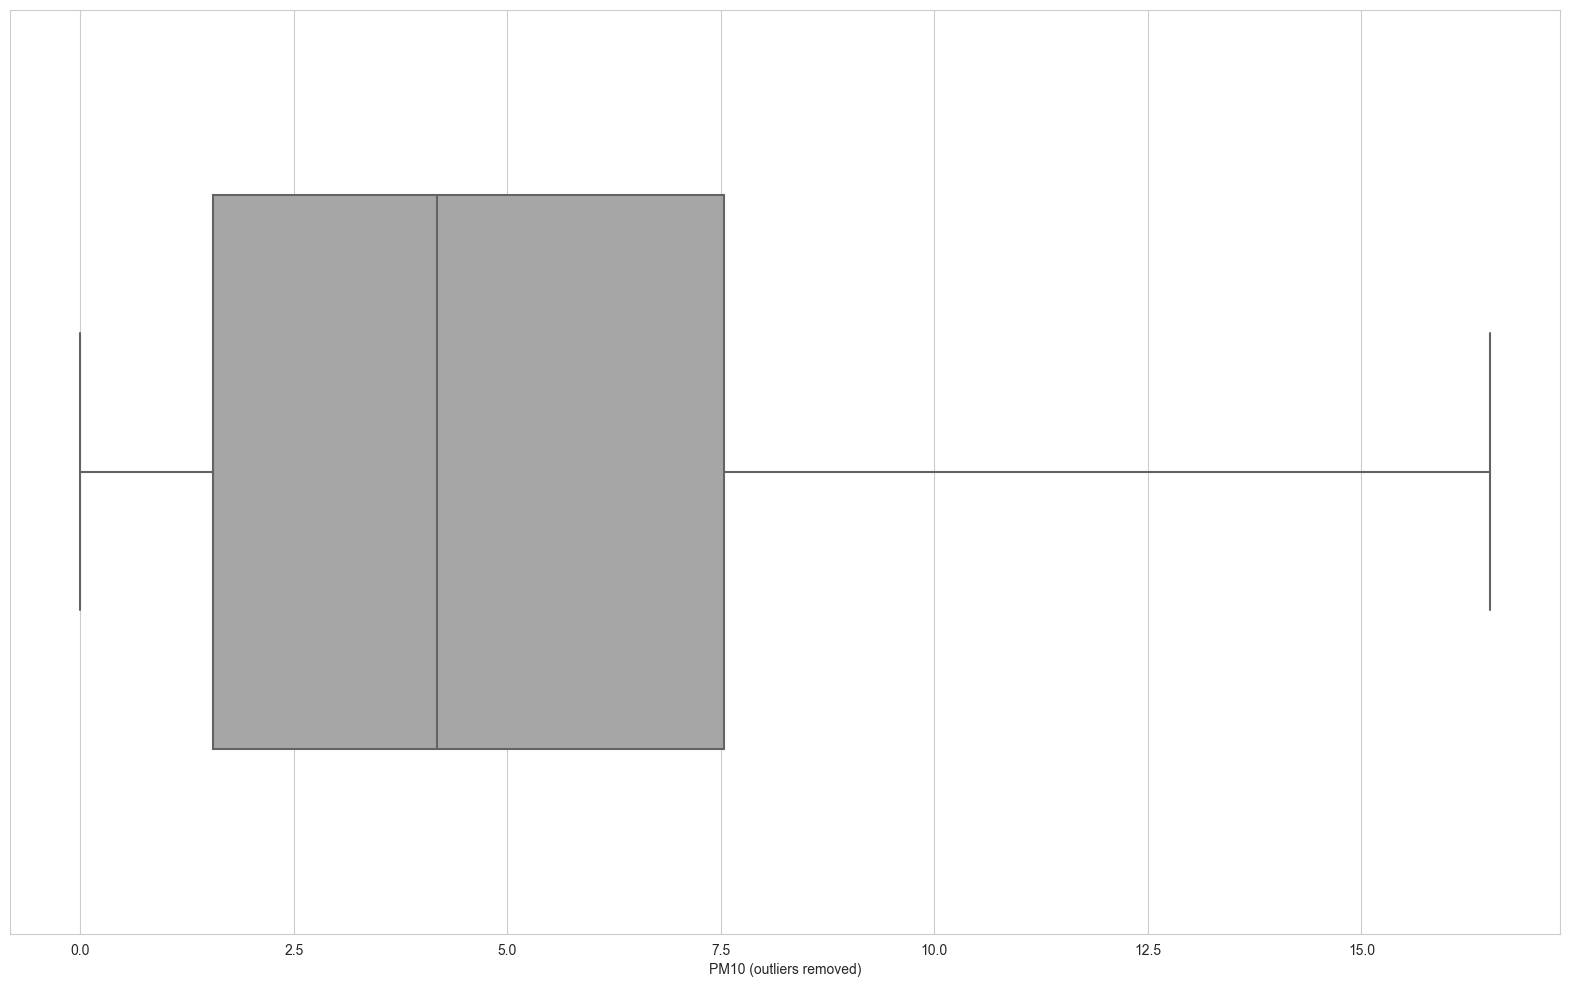

In [82]:
import matplotlib.pyplot as plt 
%matplotlib inline


def box_plots(df, data_params):
    
#     print(df.shape)
    fig, ax = plt.subplots()
    sns.set_style("whitegrid")
    
    ax.set_aspect=(1.5) 
    flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none')

    sns.boxplot(x=df['Value'], width=0.6, color=".65", flierprops=flierprops)
    plt.xlabel(data_params["data_variable"])
    plt.show()

    sns.boxplot(x=df['Value'], width=0.6, color=".65", showfliers=False)
    plt.xlabel(data_params["data_variable"]+" (outliers removed)")
    plt.show()
    
def kde_plot(df):
    # kde plot
    sns.displot(data=df, x=df['Value'], kind="kde")
    sns.displot(data=df, x=df['Value'])
    plt.show()

for i in range(0, len(AggData.instances)):
    box_plots(AggData.instances[i].df, AggData.instances[i].data_params)


In [11]:
def Remove_Suspect(df):
    
    # Drop rows containing NaN values
    df.dropna(inplace=True)

    # Remove rows with 'Value' <= 0
    df = df[df['Value'] > 0]

    # Remove flagged as suspect readings
    df = df[df['Flagged as Suspect Reading'] == False]

    return df


def Remove_Outlier_Indices(df):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList


def iqr_method(df):
    
    nonOutliers = Remove_Outlier_Indices(df['Value'])

    # Non-Outlier Subset of the Given Dataset
    dfIQR = df[nonOutliers]
    return dfIQR

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import numpy as np
import contextily as ctx

def plot_sensor_spikes(df, scale_factor=40):
    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Sensor Centroid Longitude'], df['Sensor Centroid Latitude']))

    # Set CRS for the GeoDataFrame
    gdf = gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")

    # Set all angles to 0 degrees (up)
    gdf['angle'] = 0

    # Create the create_spike function as before, but set the angle to 0 degrees (up)
    def create_spike(row, scale_factor):
        centroid = row.geometry.centroid
        spike_length = row['Value'] * scale_factor
        angle = 0  # Set the angle to 0 degrees (up)

        end_y = centroid.y + spike_length * np.cos(np.deg2rad(angle))
        end_x = centroid.x + spike_length * np.sin(np.deg2rad(angle))
        spike_line = LineString([(centroid.x, centroid.y), (end_x, end_y)])

        return spike_line

    # Create a copy of the GeoDataFrame and apply the create_spike function
    gdf_spikes = gdf.copy()
    gdf_spikes['geometry'] = gdf.apply(create_spike, scale_factor=scale_factor, axis=1)

    # Plot the spikes on the map
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.geometry.plot(ax=ax, markersize=10, color='blue')  # Plot the sensor locations
    gdf_spikes.plot(ax=ax, linewidth=2, color='red')  # Plot the spikes
    plt.axis('equal')  # Set equal aspect ratio

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()

    plt.show()


In [70]:
import folium
from folium.plugins import MarkerCluster

def create_sensor_spike_map(gdf, location=[54.9714, -1.6174], zoom_start=12, scale_factor=30):
    # Create an empty Folium Map object centered at Newcastle upon Tyne
    m = folium.Map(location=location, zoom_start=zoom_start)

    # Filter out rows with missing values
    gdf_filtered = gdf.dropna(subset=['Value'])

    # Iterate through the filtered GeoDataFrame and add each spike to the map
    for index, row in gdf_filtered.iterrows():
        # Create the spike
        centroid = row.geometry.centroid
        spike_length = row['Value'] * scale_factor
        angle = 0  # Set the angle to 0 degrees (up)

        end_y = centroid.y + spike_length * np.cos(np.deg2rad(angle))
        end_x = centroid.x + spike_length * np.sin(np.deg2rad(angle))
        spike_line = LineString([(centroid.x, centroid.y), (end_x, end_y)])

        # Convert the spike's coordinates from Web Mercator to WGS84
        spike_wgs84 = gpd.GeoSeries(spike_line, crs="EPSG:3857").to_crs("EPSG:4326").iloc[0]

        # Add the spike to the map
        folium.PolyLine(
            locations=[(spike_wgs84.coords[0][1], spike_wgs84.coords[0][0]),
                       (spike_wgs84.coords[1][1], spike_wgs84.coords[1][0])],
            color='red',
            weight=2.5,
            opacity=0.8
        ).add_to(m)

    return m



20:55:03 - cmdstanpy - INFO - Chain [1] start processing
20:55:05 - cmdstanpy - INFO - Chain [1] done processing


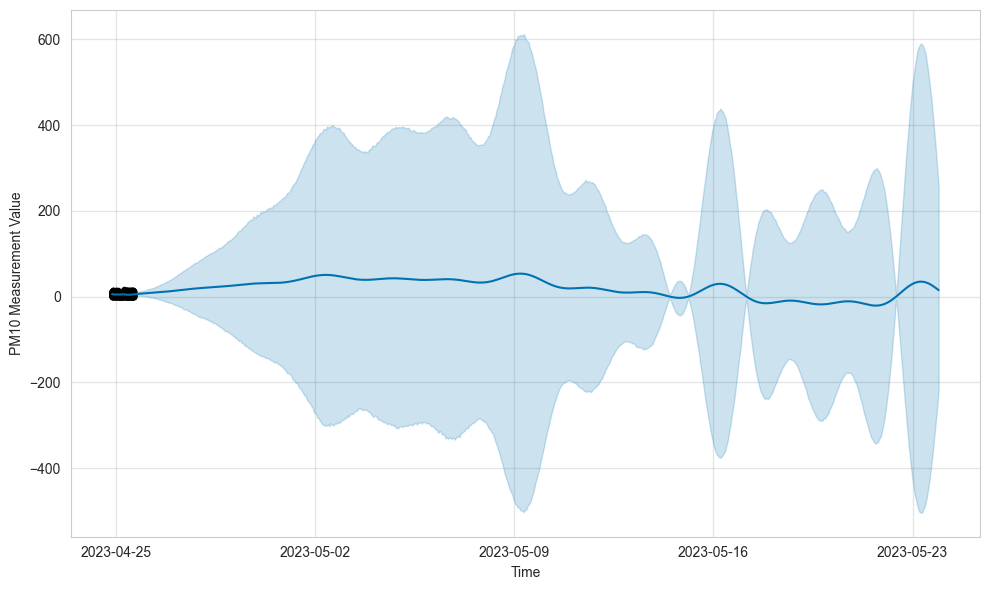

Mean Absolute Error: 22.64


22.635086239349995

In [66]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

def prophet_forecast(input_df):
    # Clean and prepare the data
    df = Remove_Suspect(input_df.df)
    df = iqr_method(df)
    # Select relevant columns and rename them as required by Prophet
    df = df[['Timestamp', 'Value']]
    df.columns = ['ds', 'y']

    # Make sure the 'ds' column is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])

    # Split the data into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    # Initialize and fit the Prophet model with tuned hyperparameters
    model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5, yearly_seasonality=10, weekly_seasonality=True)
    model.fit(train_df)

    # Make predictions for the test set
    future = model.make_future_dataframe(periods=len(test_df), freq='H')
    forecast = model.predict(future)

    # Plot the predictions
    fig = model.plot(forecast)

    # Set the Y-axis label
    ax = fig.gca()
    ax.set_ylabel(str(input_df) +' Measurement Value')

    # Optionally, you can set the X-axis label as well
    ax.set_xlabel('Time')

    plt.show()

    # Calculate the Mean Absolute Error (MAE) to evaluate the model's performance
    mae = mean_absolute_error(test_df['y'], forecast['yhat'].tail(len(test_df)))
    print(f"Mean Absolute Error: {mae:.2f}")

    return mae

a=AggData("PM10")
prophet_forecast(a)

In [88]:
from ipywidgets import interactive, Layout, widgets

# Create a dropdown widget to select the plot type
plot_type_selector = widgets.Dropdown(options=['Line Graph', 'KDE Plot', 'Sensor Spike Map', 'Sensor Map', 'Prophet Forecast'], description='Plot Type:', layout=Layout(width='auto', height='auto'))

# Create a widget to hold the plot output
plot_output = widgets.Output(layout=widgets.Layout(width='100%', height='auto', overflow='visible'))

%matplotlib inline
import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = [20, 12]  # Increase the figure size here
#plt.rcParams['figure.dpi'] = 100


def plot_dashboard(variable1, variable2, plot_type):
    
    # Find the AggData instance with the selected data variables
    selected_agg_data1 = None
    selected_agg_data2 = None
    for instance in AggData.instances:
        if instance.data_params["data_variable"] == variable1:
            selected_agg_data1 = instance
        if instance.data_params["data_variable"] == variable2:
            selected_agg_data2 = instance
        if selected_agg_data1 is not None and selected_agg_data2 is not None:
            break

    if selected_agg_data1 is not None and selected_agg_data2 is not None:
        # Clear the plot output widget
        plot_output.clear_output()
        
        # Plot the data based on the selected plot type
        with plot_output:

            if plot_type == 'Line Graph':
                #plot_line_graph(selected_agg_data1.df, selected_agg_data1.data_params)
                df1 = Remove_Suspect(selected_agg_data1.df)
                dfIQR1 = iqr_method(df1)
                print("Outliers Removed:")
                plot_line_graph(dfIQR1, selected_agg_data1.data_params)

                #plot_line_graph(selected_agg_data2.df, selected_agg_data2.data_params)
                df2 = Remove_Suspect(selected_agg_data2.df)
                dfIQR2 = iqr_method(df2)
                print("Outliers Removed:")
                plot_line_graph(dfIQR2, selected_agg_data2.data_params)

            elif plot_type == 'KDE Plot':
                df1 = Remove_Suspect(selected_agg_data1.df)
                dfIQR1 = iqr_method(df1)
                kde_plot(df1)

            elif plot_type == 'Sensor Spike Map':
                df1 = Remove_Suspect(selected_agg_data1.df)
                dfIQR1 = iqr_method(df1)
                gdf = gpd.GeoDataFrame(dfIQR1, geometry=gpd.points_from_xy(dfIQR1['Sensor Centroid Longitude'],dfIQR1['Sensor Centroid Latitude']))
                sensor_spike_map = create_sensor_spike_map(gdf, location=[54.9714, -1.6174], zoom_start=12, scale_factor=30)
                display(sensor_spike_map)

            elif plot_type == 'Sensor Map':
                df1 = Remove_Suspect(selected_agg_data1.df)
                dfIQR1 = iqr_method(df1)
                gdf = gpd.GeoDataFrame(dfIQR1, geometry=gpd.points_from_xy(dfIQR1['Sensor Centroid Longitude'], dfIQR1['Sensor Centroid Latitude']))
                plot_sensor_spikes(gdf)

            elif plot_type == 'Prophet Forecast':
                print("Prophet Forecast for Variable 1:")
                prophet_forecast(selected_agg_data1)

                print("Prophet Forecast for Variable 2:")
                prophet_forecast(selected_agg_data2)



                
def update_plot_type_options(change):
    if change['new'] in ['Sensor Spike Map', 'Sensor Map', 'KDE Plot']:
        variable_selector2.disabled = True
    else:
        variable_selector1.disabled = False
        variable_selector2.disabled = False

plot_type_selector.observe(update_plot_type_options, 'value')
# Create dropdown widgets to select the variables
variable_selector1 = widgets.Dropdown(options=['PM2.5', 'PM10', 'NO2'], description='Variable 1:', layout=Layout(width='auto', height='auto'))
variable_selector2 = widgets.Dropdown(options=['PM2.5', 'PM10', 'NO2'], description='Variable 2:', layout=Layout(width='auto', height='auto'))

dashboard = interactive(plot_dashboard, variable1=variable_selector1, variable2=variable_selector2, plot_type=plot_type_selector)
box_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', width='100%')
display(widgets.Box([variable_selector1, variable_selector2, plot_type_selector, plot_output, dashboard.children[-1]], layout=box_layout))

     

Box(children=(Dropdown(description='Variable 1:', layout=Layout(height='auto', width='auto'), options=('PM2.5'…

In [60]:
from ipywidgets import Tab

line_graph_tab = widgets.VBox([variable_selector1, variable_selector2, plot_output, dashboard.children[-1]])
kde_plot_tab = widgets.VBox([variable_selector1, variable_selector2, plot_output, dashboard.children[-1]])
sensor_spike_map_tab = widgets.VBox([plot_output])
sensor_map_tab = widgets.VBox([variable_selector1, variable_selector2, plot_output, dashboard.children[-1]])
prophet_forecast_tab = widgets.VBox([variable_selector1, variable_selector2, plot_output, dashboard.children[-1]])

tab_widget = Tab()
tab_widget.children = [line_graph_tab, kde_plot_tab, sensor_spike_map_tab, sensor_map_tab, prophet_forecast_tab]
tab_widget.set_title(0, 'Line Graph')
tab_widget.set_title(1, 'KDE Plot')
tab_widget.set_title(2, 'Sensor Spike Map')
tab_widget.set_title(3, 'Sensor Map')
tab_widget.set_title(4, 'Prophet Forecast')

# Display the tab widget
display(tab_widget)
